### Problem 3: implement a temporal recognition network (e.g.,ResNet50+LSTM) to classify the surgical phase recognition

In [1]:
import random
import shutil
import time
import warnings
import sys
import torch
import torch.nn as nn
import numpy as np
import os
import pandas as pd
from PIL import Image
import torch.nn.parallel
from tqdm import tqdm
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim as optim
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torchvision.models as models
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import torch.nn.init as init
from PIL import Image
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


In [3]:
#dataset
import csv
class Surgical(Dataset): 

    def __init__(self, root="./datas", train=True, transform=None, video=0):
        self.train = train
        self.video = str(video)
        if(self.train):

            Phase_path = "./datas/annotation/video_{number}.csv".format(number=self.video)
            self.phasepath = os.path.join(Phase_path)

            frame_path = "./datas/{number}".format(number=self.video)
            self.root = os.path.join(frame_path)
            #video_41 is test file.
        else:
            self.phasepath = os.path.join("./datas/annotation/video_41.csv")
            self.root = os.path.join("./datas/41")
        # Transforms
        self.transform = transform


    def __getitem__(self, index):
 
        csv = pd.read_csv(self.phasepath)
        data = csv 
        label = data.iloc[index, 1]
        image = Image.open(os.path.join(self.root, data.iloc[index, 0]))
        image = self.transform(image)    
        return image, label


    def __len__(self):
        csv = pd.read_csv(self.phasepath)
        return len(csv)


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs =80
#sequence_length = 3
learning_rate = 5e-4
batch_size = 50

In [5]:
train_transform = transforms.Compose([transforms.RandomRotation(35),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(180, translate=[0.2, 0.2], scale=[0.8, 1.2]),
                                      transforms.ColorJitter(0.02, 0.02, 0.02, 0.01),
                                      transforms.RandomResizedCrop(200),
                                      transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize(200),
                                     transforms.ToTensor()])


trainset_1 = Surgical(train=True, transform=train_transform, video=1)  
trainset_2 = Surgical(train=True, transform=train_transform, video=2)
trainset_3 = Surgical(train=True, transform=train_transform, video=3)
trainset_4 = Surgical(train=True, transform=train_transform, video=4)
trainset_5 = Surgical(train=True, transform=train_transform, video=5)
testset = Surgical(train=False, transform=test_transform)

In [6]:
trainloader_1 = torch.utils.data.DataLoader(trainset_1, batch_size=batch_size,
                                          shuffle=True, pin_memory=True)
trainloader_2 = torch.utils.data.DataLoader(trainset_2, batch_size=batch_size,
                                          shuffle=True, pin_memory=True)
trainloader_3 = torch.utils.data.DataLoader(trainset_3, batch_size=batch_size,
                                          shuffle=True, pin_memory=True)
trainloader_4 = torch.utils.data.DataLoader(trainset_4, batch_size=batch_size,
                                          shuffle=True, pin_memory=True)
trainloader_5 = torch.utils.data.DataLoader(trainset_5, batch_size=batch_size,
                                          shuffle=True, pin_memory=True)                                                                                                                                          
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        shuffle=False, pin_memory=True)

In [8]:
from torchvision.models import resnet

resnet.model_urls["resnet50"] = "https://download.pytorch.org/models/resnet50-11ad3fa6.pth"
   
  # Initialize the model using the legacy API
model = resnet.resnet50(pretrained=True)
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, 7)
)
model = model.to(device)
#print(model)

In [9]:
#loss
loss_fn= nn.CrossEntropyLoss().to(device)

In [10]:
# Train 
epochs =80
#sequence_length = 3
learning_rate = 5e-4
batch_size = 50
max_acc = 0
train_Acc_list = []
train_loss_list = []
test_Acc_list = []
test_Prec_list = []
test_rec_list = []
test_loss_list = []
train_path = "train.path"
test_path = "test.path"
trainloader = trainloader_1
def train(model, trainloader,testloader,loss_fn, learning_rate,max_acc):
    for epoch in range(1, epochs+1):
        print(f"Epoch {epoch}\n-------------------------------")
        if epoch % 10 == 0:
            learning_rate = learning_rate * 0.5
            optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=1e-5)
        else:
            optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=1e-5)

        model.train()

        t_loss = 0
        correct = 0
        current = 0
        
        number = epoch % 10
        if number > 5:
            number -= 5
        if number == 1:
            trainset = trainset_1
            trainloader = trainloader_1
        elif number == 2:
            trainset = trainset_2
            trainloader = trainloader_2
        elif number == 3:
            trainset = trainset_3
            trainloader = trainloader_3
        elif number == 4:
            trainset = trainset_4
            trainloader = trainloader_4
        else:
            trainset = trainset_5
            trainloader = trainloader_5
    
        
        for batch_idx, (data,target) in tqdm(enumerate(trainloader)):
            optimizer.zero_grad()

            X, y = data, target

            X = X.to(device)
            y = y.to(device)
        
            output = model(X)
        
            loss = loss_fn(output, y)
        
            loss.backward()
            optimizer.step()
            pred = torch.argmax(output, dim=1)
        
            t_loss += loss.item()
            correct += torch.sum(pred == y)
            
        train_loss = t_loss/len(trainset)
        train_acc = correct/len(trainset)  
        writer.add_scalar("Train Loss", train_loss, epoch)
        writer.add_scalar("Train Accuracy", train_acc, epoch)
        print('=>train accuracy: {:.4f}'.format(train_acc))
        print('=>train loss: {:.4f}'.format(train_loss))
        train_Acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        if epoch % 20 == 0:
            torch.save(model.state_dict(), train_path)
        test(model, testloader, epoch,loss_fn,max_acc) 
   

In [11]:
def test(model, testloader, epoch,loss_fn,max_acc) :
    model.eval()
    gt_list = []
    pred_list = []
    te_loss= 0
    correct = 0 
    for _, (data,target) in enumerate(testloader):
        X, y = data, target
        X = X.to(device)
        y = y.to(device)
        output = model(X)
        pred = torch.argmax(output, dim=1)
        pred = pred.cpu()
        pred_list.extend(pred)
        gt_list.extend(y)
        te_loss += loss_fn(output, y).item()
    test_acc = accuracy_score(gt_list, pred_list)
    if test_acc > max_acc:
        max_acc = test_acc
        torch.save(model.state_dict(), test_path)     
            
    test_loss = te_loss/len(testset)
    writer.add_scalar("Test Accuracy", test_acc, epoch)
    writer.add_scalar("Test Loss", test_loss, epoch)

    print('=>test accuracy: {:.4f}'.format(test_acc))
    print('=>test loss: {:.4f}'.format(test_loss))
    test_Acc_list.append(test_acc)
    test_loss_list.append(test_loss)

In [12]:
writer = SummaryWriter() 
train(model, trainloader,testloader,loss_fn, learning_rate,max_acc)
writer.flush()
writer.close()

Epoch 1
-------------------------------


9it [01:02,  7.00s/it]


=>train accuracy: 0.4286
=>train loss: 0.0321
=>test accuracy: 0.4008
=>test loss: 0.0459
Epoch 2
-------------------------------


15it [01:38,  6.56s/it]


=>train accuracy: 0.5183
=>train loss: 0.0282
=>test accuracy: 0.2938
=>test loss: 0.0338
Epoch 3
-------------------------------


30it [03:20,  6.67s/it]


=>train accuracy: 0.7243
=>train loss: 0.0183
=>test accuracy: 0.4021
=>test loss: 0.0326
Epoch 4
-------------------------------


8it [00:53,  6.63s/it]


=>train accuracy: 0.4042
=>train loss: 0.0366
=>test accuracy: 0.4678
=>test loss: 0.0332
Epoch 5
-------------------------------


12it [01:21,  6.83s/it]


=>train accuracy: 0.4906
=>train loss: 0.0275
=>test accuracy: 0.3093
=>test loss: 0.0382
Epoch 6
-------------------------------


9it [01:00,  6.74s/it]


=>train accuracy: 0.6359
=>train loss: 0.0217
=>test accuracy: 0.4523
=>test loss: 0.0496
Epoch 7
-------------------------------


15it [01:38,  6.59s/it]


=>train accuracy: 0.5155
=>train loss: 0.0278
=>test accuracy: 0.4626
=>test loss: 0.0289
Epoch 8
-------------------------------


30it [03:20,  6.67s/it]


=>train accuracy: 0.7730
=>train loss: 0.0151
=>test accuracy: 0.2758
=>test loss: 0.0481
Epoch 9
-------------------------------


8it [00:52,  6.53s/it]


=>train accuracy: 0.4619
=>train loss: 0.0355
=>test accuracy: 0.4381
=>test loss: 0.0328
Epoch 10
-------------------------------


12it [01:20,  6.75s/it]


=>train accuracy: 0.6354
=>train loss: 0.0220
=>test accuracy: 0.2629
=>test loss: 0.0539
Epoch 11
-------------------------------


9it [00:59,  6.64s/it]


=>train accuracy: 0.6521
=>train loss: 0.0203
=>test accuracy: 0.3982
=>test loss: 0.0403
Epoch 12
-------------------------------


15it [01:38,  6.55s/it]


=>train accuracy: 0.5239
=>train loss: 0.0246
=>test accuracy: 0.5464
=>test loss: 0.0265
Epoch 13
-------------------------------


30it [03:21,  6.73s/it]


=>train accuracy: 0.7840
=>train loss: 0.0136
=>test accuracy: 0.4729
=>test loss: 0.0266
Epoch 14
-------------------------------


8it [00:53,  6.66s/it]


=>train accuracy: 0.4961
=>train loss: 0.0311
=>test accuracy: 0.5992
=>test loss: 0.0232
Epoch 15
-------------------------------


12it [01:21,  6.78s/it]


=>train accuracy: 0.6610
=>train loss: 0.0211
=>test accuracy: 0.5219
=>test loss: 0.0287
Epoch 16
-------------------------------


9it [01:00,  6.71s/it]


=>train accuracy: 0.6613
=>train loss: 0.0179
=>test accuracy: 0.4768
=>test loss: 0.0267
Epoch 17
-------------------------------


15it [01:37,  6.51s/it]


=>train accuracy: 0.6211
=>train loss: 0.0218
=>test accuracy: 0.4884
=>test loss: 0.0296
Epoch 18
-------------------------------


30it [03:21,  6.73s/it]


=>train accuracy: 0.8134
=>train loss: 0.0119
=>test accuracy: 0.5631
=>test loss: 0.0235
Epoch 19
-------------------------------


8it [00:53,  6.66s/it]


=>train accuracy: 0.4961
=>train loss: 0.0283
=>test accuracy: 0.5696
=>test loss: 0.0237
Epoch 20
-------------------------------


12it [01:21,  6.79s/it]


=>train accuracy: 0.6593
=>train loss: 0.0194
=>test accuracy: 0.5812
=>test loss: 0.0256
Epoch 21
-------------------------------


9it [00:59,  6.65s/it]


=>train accuracy: 0.7396
=>train loss: 0.0152
=>test accuracy: 0.5941
=>test loss: 0.0245
Epoch 22
-------------------------------


15it [01:37,  6.52s/it]


=>train accuracy: 0.6211
=>train loss: 0.0215
=>test accuracy: 0.6662
=>test loss: 0.0217
Epoch 23
-------------------------------


30it [03:21,  6.71s/it]


=>train accuracy: 0.8409
=>train loss: 0.0107
=>test accuracy: 0.6379
=>test loss: 0.0207
Epoch 24
-------------------------------


8it [00:52,  6.61s/it]


=>train accuracy: 0.5407
=>train loss: 0.0273
=>test accuracy: 0.6353
=>test loss: 0.0209
Epoch 25
-------------------------------


12it [01:21,  6.82s/it]


=>train accuracy: 0.7087
=>train loss: 0.0176
=>test accuracy: 0.5490
=>test loss: 0.0242
Epoch 26
-------------------------------


9it [01:03,  7.06s/it]


=>train accuracy: 0.7465
=>train loss: 0.0146
=>test accuracy: 0.5889
=>test loss: 0.0231
Epoch 27
-------------------------------


15it [01:44,  6.96s/it]


=>train accuracy: 0.6648
=>train loss: 0.0191
=>test accuracy: 0.5915
=>test loss: 0.0225
Epoch 28
-------------------------------


30it [03:37,  7.25s/it]


=>train accuracy: 0.8416
=>train loss: 0.0103
=>test accuracy: 0.6894
=>test loss: 0.0208
Epoch 29
-------------------------------


8it [00:57,  7.19s/it]


=>train accuracy: 0.5564
=>train loss: 0.0251
=>test accuracy: 0.6340
=>test loss: 0.0214
Epoch 30
-------------------------------


12it [01:27,  7.30s/it]


=>train accuracy: 0.7070
=>train loss: 0.0179
=>test accuracy: 0.6263
=>test loss: 0.0231
Epoch 31
-------------------------------


9it [01:05,  7.27s/it]


=>train accuracy: 0.7719
=>train loss: 0.0129
=>test accuracy: 0.5941
=>test loss: 0.0228
Epoch 32
-------------------------------


15it [01:46,  7.13s/it]


=>train accuracy: 0.6761
=>train loss: 0.0163
=>test accuracy: 0.6778
=>test loss: 0.0195
Epoch 33
-------------------------------


30it [03:40,  7.36s/it]


=>train accuracy: 0.8745
=>train loss: 0.0093
=>test accuracy: 0.7242
=>test loss: 0.0183
Epoch 34
-------------------------------


8it [00:58,  7.26s/it]


=>train accuracy: 0.6194
=>train loss: 0.0214
=>test accuracy: 0.6778
=>test loss: 0.0204
Epoch 35
-------------------------------


12it [01:29,  7.43s/it]


=>train accuracy: 0.6951
=>train loss: 0.0181
=>test accuracy: 0.6353
=>test loss: 0.0227
Epoch 36
-------------------------------


9it [01:06,  7.38s/it]


=>train accuracy: 0.7512
=>train loss: 0.0128
=>test accuracy: 0.5412
=>test loss: 0.0255
Epoch 37
-------------------------------


15it [01:48,  7.20s/it]


=>train accuracy: 0.6873
=>train loss: 0.0171
=>test accuracy: 0.6662
=>test loss: 0.0207
Epoch 38
-------------------------------


30it [03:42,  7.41s/it]


=>train accuracy: 0.8765
=>train loss: 0.0088
=>test accuracy: 0.6933
=>test loss: 0.0193
Epoch 39
-------------------------------


8it [00:57,  7.23s/it]


=>train accuracy: 0.6325
=>train loss: 0.0203
=>test accuracy: 0.7126
=>test loss: 0.0197
Epoch 40
-------------------------------


12it [01:28,  7.40s/it]


=>train accuracy: 0.6985
=>train loss: 0.0181
=>test accuracy: 0.7397
=>test loss: 0.0198
Epoch 41
-------------------------------


9it [01:05,  7.29s/it]


=>train accuracy: 0.7097
=>train loss: 0.0129
=>test accuracy: 0.7036
=>test loss: 0.0196
Epoch 42
-------------------------------


15it [01:46,  7.13s/it]


=>train accuracy: 0.6704
=>train loss: 0.0173
=>test accuracy: 0.7294
=>test loss: 0.0193
Epoch 43
-------------------------------


30it [03:46,  7.55s/it]


=>train accuracy: 0.8779
=>train loss: 0.0079
=>test accuracy: 0.7088
=>test loss: 0.0200
Epoch 44
-------------------------------


8it [00:58,  7.34s/it]


=>train accuracy: 0.6614
=>train loss: 0.0193
=>test accuracy: 0.6946
=>test loss: 0.0209
Epoch 45
-------------------------------


12it [01:29,  7.43s/it]


=>train accuracy: 0.7394
=>train loss: 0.0162
=>test accuracy: 0.6869
=>test loss: 0.0212
Epoch 46
-------------------------------


9it [01:05,  7.33s/it]


=>train accuracy: 0.7650
=>train loss: 0.0115
=>test accuracy: 0.6314
=>test loss: 0.0216
Epoch 47
-------------------------------


15it [01:46,  7.13s/it]


=>train accuracy: 0.6831
=>train loss: 0.0166
=>test accuracy: 0.7049
=>test loss: 0.0200
Epoch 48
-------------------------------


30it [04:19,  8.64s/it]


=>train accuracy: 0.8855
=>train loss: 0.0076
=>test accuracy: 0.7165
=>test loss: 0.0193
Epoch 49
-------------------------------


8it [00:57,  7.23s/it]


=>train accuracy: 0.6562
=>train loss: 0.0186
=>test accuracy: 0.7152
=>test loss: 0.0195
Epoch 50
-------------------------------


12it [01:29,  7.42s/it]


=>train accuracy: 0.7428
=>train loss: 0.0158
=>test accuracy: 0.6804
=>test loss: 0.0207
Epoch 51
-------------------------------


9it [01:05,  7.25s/it]


=>train accuracy: 0.7604
=>train loss: 0.0123
=>test accuracy: 0.6985
=>test loss: 0.0194
Epoch 52
-------------------------------


15it [01:46,  7.12s/it]


=>train accuracy: 0.6915
=>train loss: 0.0158
=>test accuracy: 0.7384
=>test loss: 0.0183
Epoch 53
-------------------------------


30it [03:39,  7.31s/it]


=>train accuracy: 0.8848
=>train loss: 0.0075
=>test accuracy: 0.7113
=>test loss: 0.0196
Epoch 54
-------------------------------


8it [00:58,  7.27s/it]


=>train accuracy: 0.6903
=>train loss: 0.0198
=>test accuracy: 0.6946
=>test loss: 0.0203
Epoch 55
-------------------------------


12it [01:28,  7.40s/it]


=>train accuracy: 0.7513
=>train loss: 0.0157
=>test accuracy: 0.6817
=>test loss: 0.0211
Epoch 56
-------------------------------


9it [01:05,  7.27s/it]


=>train accuracy: 0.7995
=>train loss: 0.0116
=>test accuracy: 0.7075
=>test loss: 0.0194
Epoch 57
-------------------------------


15it [01:47,  7.19s/it]


=>train accuracy: 0.6944
=>train loss: 0.0167
=>test accuracy: 0.7564
=>test loss: 0.0187
Epoch 58
-------------------------------


30it [03:40,  7.35s/it]


=>train accuracy: 0.8841
=>train loss: 0.0076
=>test accuracy: 0.7178
=>test loss: 0.0190
Epoch 59
-------------------------------


8it [00:57,  7.25s/it]


=>train accuracy: 0.6982
=>train loss: 0.0173
=>test accuracy: 0.7216
=>test loss: 0.0194
Epoch 60
-------------------------------


12it [01:28,  7.42s/it]


=>train accuracy: 0.7411
=>train loss: 0.0151
=>test accuracy: 0.6959
=>test loss: 0.0205
Epoch 61
-------------------------------


9it [01:05,  7.24s/it]


=>train accuracy: 0.7742
=>train loss: 0.0117
=>test accuracy: 0.7191
=>test loss: 0.0191
Epoch 62
-------------------------------


15it [01:48,  7.20s/it]


=>train accuracy: 0.6930
=>train loss: 0.0150
=>test accuracy: 0.7474
=>test loss: 0.0185
Epoch 63
-------------------------------


30it [03:41,  7.38s/it]


=>train accuracy: 0.8971
=>train loss: 0.0069
=>test accuracy: 0.7152
=>test loss: 0.0192
Epoch 64
-------------------------------


8it [00:57,  7.22s/it]


=>train accuracy: 0.6352
=>train loss: 0.0189
=>test accuracy: 0.7126
=>test loss: 0.0201
Epoch 65
-------------------------------


12it [01:28,  7.37s/it]


=>train accuracy: 0.7683
=>train loss: 0.0136
=>test accuracy: 0.6920
=>test loss: 0.0208
Epoch 66
-------------------------------


9it [01:05,  7.29s/it]


=>train accuracy: 0.7719
=>train loss: 0.0114
=>test accuracy: 0.7204
=>test loss: 0.0191
Epoch 67
-------------------------------


15it [01:47,  7.14s/it]


=>train accuracy: 0.6887
=>train loss: 0.0160
=>test accuracy: 0.7423
=>test loss: 0.0188
Epoch 68
-------------------------------


30it [03:42,  7.41s/it]


=>train accuracy: 0.8951
=>train loss: 0.0067
=>test accuracy: 0.7113
=>test loss: 0.0188
Epoch 69
-------------------------------


8it [00:58,  7.27s/it]


=>train accuracy: 0.6877
=>train loss: 0.0183
=>test accuracy: 0.7088
=>test loss: 0.0200
Epoch 70
-------------------------------


12it [01:29,  7.43s/it]


=>train accuracy: 0.7547
=>train loss: 0.0142
=>test accuracy: 0.6778
=>test loss: 0.0206
Epoch 71
-------------------------------


9it [01:06,  7.34s/it]


=>train accuracy: 0.7903
=>train loss: 0.0120
=>test accuracy: 0.7268
=>test loss: 0.0188
Epoch 72
-------------------------------


15it [01:47,  7.17s/it]


=>train accuracy: 0.6831
=>train loss: 0.0164
=>test accuracy: 0.7526
=>test loss: 0.0176
Epoch 73
-------------------------------


30it [03:41,  7.37s/it]


=>train accuracy: 0.9060
=>train loss: 0.0064
=>test accuracy: 0.7191
=>test loss: 0.0197
Epoch 74
-------------------------------


8it [00:57,  7.18s/it]


=>train accuracy: 0.6955
=>train loss: 0.0166
=>test accuracy: 0.7049
=>test loss: 0.0205
Epoch 75
-------------------------------


12it [01:29,  7.42s/it]


=>train accuracy: 0.7683
=>train loss: 0.0148
=>test accuracy: 0.6843
=>test loss: 0.0214
Epoch 76
-------------------------------


9it [01:06,  7.36s/it]


=>train accuracy: 0.8018
=>train loss: 0.0104
=>test accuracy: 0.7113
=>test loss: 0.0193
Epoch 77
-------------------------------


15it [01:48,  7.21s/it]


=>train accuracy: 0.6803
=>train loss: 0.0166
=>test accuracy: 0.7500
=>test loss: 0.0183
Epoch 78
-------------------------------


30it [04:08,  8.27s/it]


=>train accuracy: 0.9005
=>train loss: 0.0067
=>test accuracy: 0.7165
=>test loss: 0.0193
Epoch 79
-------------------------------


8it [00:58,  7.31s/it]


=>train accuracy: 0.7113
=>train loss: 0.0174
=>test accuracy: 0.7049
=>test loss: 0.0203
Epoch 80
-------------------------------


12it [01:31,  7.65s/it]


=>train accuracy: 0.7564
=>train loss: 0.0142
=>test accuracy: 0.6933
=>test loss: 0.0207


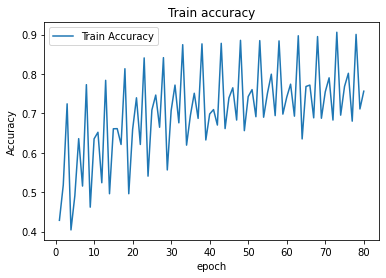

In [14]:
#plot train accuracy in each epoch
import matplotlib.pyplot as plt
%matplotlib inline
dim1 = []
dim1.extend(range(1, 81))
plt.plot(dim1,train_Acc_list,label='Train Accuracy')
plt.title('Train accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

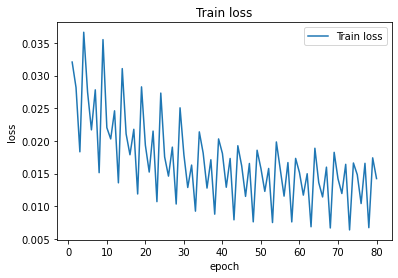

In [15]:
#plot train loss in each epochimport matplotlib.pyplot as plt
plt.plot(dim1,train_loss_list,label='Train loss')
plt.title('Train loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

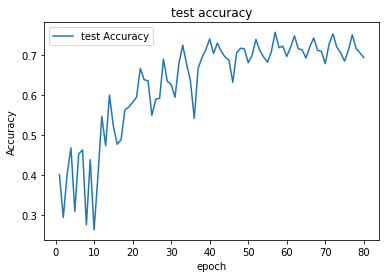

In [16]:
#plot test accuracy in each epochimport matplotlib.pyplot as plt
plt.plot(dim1,test_Acc_list,label='test Accuracy')
plt.title('test accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

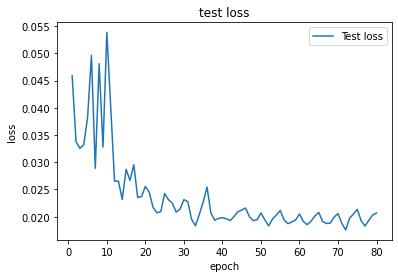

In [17]:
#plot test loss in each epochimport matplotlib.pyplot as plt
plt.plot(dim1,test_loss_list,label='Test loss')
plt.title('test loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()